Este notebook está estruturado em células de análise, seguidas de células com as conclusões e encaminhamentos resultantes.

Descoberta 1 ...
* *Encaminhamento 1.1 ...*
* *Encaminhamento 1.2 ...*

Descoberta 2 ...
* *Encaminhamento 2.1 ...*
* *Encaminhamento 2.2 ...*

In [99]:
%matplotlib inline
%run ../scripts/toolbelt.py
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

In [100]:
df = read_data()

# Relatório gerado pelo pandas_profiling


<a href="../reports/1 - dados_base.html">Link</a>


## Dados disponibilizados

**ID** é um numérico identificador único dos registros - considerar que é um dado que não carrega informação relevante para o problema
* *Utilizar como index do dataframe.*

**Marital_Status** possui valores que desconheço como valores significativos para o que entendo por "Marital Status": "Absurd", "YOLO", "Alone" (total de 7 registros)
* *Analisar os registros com esses valores, buscando verificar se há indícios de serem inválidos. Em caso positivo, remover do dataset.*

**Income:**
* possui como maior valor "666666", que chama a atenção tanto pelo padrão de repetição de dígitos, quanto por ser um valor bastante distante do segundo maior valor, "162397"
    * *Analisar o registro com esse valor, buscando verificar se há indícios de ser inválido. Em caso positivo, remover do dataset.*
* está com valor nulo em 24 registros
    * *Analisar os registros com **Income** null, buscando verificar se há indícios de serem inválidos. Em caso positivo, remover do dataset.*

**Dt_Customer** é um campo de data
* *Extrair como atributos o ano e a diferença para 2015, que é o ano do maior valor de Dt_Customer + 1 (somado 1 para ter valor mínimo = 1 e permitir calcular médias de valores por ano de relacionamento).*

**Recency** - há um atributo referente ao último mês (**NumWebVisitsMonth**)
* *Gerar atributo indicando se **Recency** > 1 mês = 30*

Todas os atributos **Mnt** possuem uma distribuição com concentração maior nos menores valores. Ex: **MntWines**

<img src="../imgs/mntwine_histogram.png" />

* *Gerar atributo com o total gasto, somando todos atributos **Mnt**.*
* *Gerar, para cada atributo **Mnt**, um atributo contendo a proporção entre seu valor e o total gasto (definido no item acima).*
* *Gerar um atributo informando qual atributo **Mnt** tem maior valor entre todos **Mnt** do registro.*

**Num{sales_channel}Purchases** representam a quantidade de compras por canal de venda (não está especificado o período a que se referem esses dados, diferente das variáveis **Mnt**, que se referem aos últimos 2 anos)
* *Gerar atributo com o total de compras, somando todos atributos **Num{sales_channel}Purchases**.*
* *Gerar, para cada atributo **Num{sales_channel}Purchases**, um atributo contendo a proporção entre seu valor e o total de compras (definido no item acima).*
* *Gerar um atributo informando qual o atributo **Num{sales_channel}Purchases** tem maior valor entre todos **Num{sales_channel}Purchases** do registro.*

**NumDealsPurchases** representa a quantidade de compras usando descontos
* *Gerar atributo com a proporção entre **NumDealsPurchases** e o total de compras (ver notas de **Num{sales_channel}Purchases**)*.

**MntGoldProds** representa o total gasto com produtos *gold*
* *Gerar atributo com a proporção entre **MntGoldProds** e o total gasto

# Análise manual dos atributos

## Year_Birth

In [101]:
yb = df["Year_Birth"]

yb_desc = yb.describe(percentiles=[.1, .25, .5, .75, .9])

yb_desc

count    2240.000000
mean     1968.805804
std        11.984069
min      1893.000000
10%      1952.000000
25%      1959.000000
50%      1970.000000
75%      1977.000000
90%      1984.000000
max      1996.000000
Name: Year_Birth, dtype: float64

**O valor mínimo é suspeito (supondo que os dados foram gerados em 1996, o valor máximo, teríamos um cliente com ~103 anos).**
* *Utilizar um critério de detecção de outliers e analisar seus valores -> analisar os valores usando inter-quartile range.*

In [102]:
iqr_outliers(yb, kind='mild')

ID
7829     1900
11004    1893
1150     1899
Name: Year_Birth, dtype: int64

In [103]:
extreme_outliers = iqr_outliers(yb, kind='extreme')
_

ID
7829     1900
11004    1893
1150     1899
Name: Year_Birth, dtype: int64

**O valor mínimo é suspeito (supondo que os dados foram gerados em 1996, o valor máximo, teríamos um cliente com ~103 anos).**
* *Analisar os registros cujos anos são extreme outliers.*

In [104]:
df.loc[extreme_outliers.index].T

ID,7829,11004,1150
Year_Birth,1900,1893,1899
Education,2n Cycle,2n Cycle,PhD
Marital_Status,Divorced,Single,Together
Income,36640.0,60182.0,83532.0
Kidhome,1,0,0
Teenhome,0,1,0
Dt_Customer,2013-09-26,2014-05-17,2013-09-26
Recency,99,23,36
MntWines,15,8,755
MntFruits,6,0,144


* *analisando os atributos não identifiquei mais indícios de serem registros inválidos -> vou removê-los da base e registrar um warn informando a situação*

In [105]:
register_warn([
    {
        "id": i, 
        "attr": "Year_Birth",
        "type": "outlier",
        "action": "deleted"
    } for i in extreme_outliers.index])

## Marital_Status

* *analisando registros com valores em "Alone", "Absurd" e "YOLO"*

In [106]:
ms = df["Marital_Status"]

ms_estranho = df.loc[ms.isin(["Alone", "Absurd", "YOLO"]), :]
ms_estranho.T

ID,433,7660,92,7734,4369,492,11133
Year_Birth,1958,1973,1988,1993,1957,1973,1973
Education,Master,PhD,Graduation,Graduation,Master,PhD,PhD
Marital_Status,Alone,Alone,Alone,Absurd,Absurd,YOLO,YOLO
Income,61331.0,35860.0,34176.0,79244.0,65487.0,48432.0,48432.0
Kidhome,1,1,1,0,0,0,0
Teenhome,1,1,0,0,0,1,1
Dt_Customer,2013-03-10,2014-05-19,2014-05-12,2012-12-19,2014-01-10,2012-10-18,2012-10-18
Recency,42,37,12,58,48,3,3
MntWines,534,15,5,471,240,322,322
MntFruits,5,0,7,102,67,3,3


* *analisando os atributos não identifiquei mais indícios de serem registros inválidos -> vou mantê-los na base, mas registrar um warn informando a situação*

In [107]:
register_warn([
    {
        "id": i, 
        "attr": "Marital_Status",
        "type": "unknown meaning",
        "action": "nothing"
    } for i in ms_estranho.index])

## Income

In [108]:
inc = df["Income"]

inc_outlier = df.loc[[inc.idxmax()], :]

inc_outlier.T

ID,9432
Year_Birth,1977
Education,Graduation
Marital_Status,Together
Income,666666.0
Kidhome,1
Teenhome,0
Dt_Customer,2013-06-02
Recency,23
MntWines,9
MntFruits,14


* *analisando os atributos não identifiquei mais indícios de serem registros inválidos -> vou removê-los da base e registrar um warn informando a situação*

In [109]:
register_warn([
    {
        "id": i, 
        "attr": "Income",
        "type": "outlier",
        "action": "deleted"
    } for i in inc_outlier.index])

* *analisando a relação entre **Income** e atributos **Mnt**, com os quais espero haver uma associação*

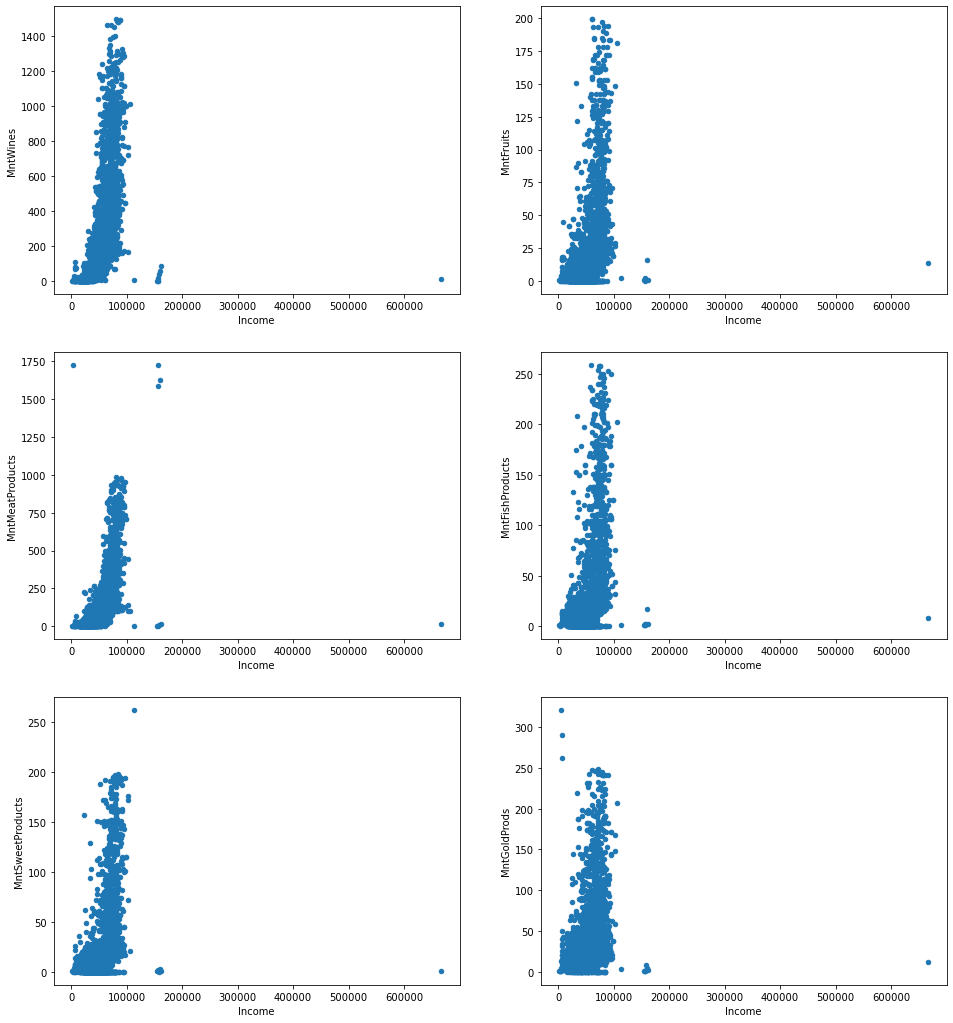

In [110]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(16, 18))

mnt_columns = [c for c in df.columns if c.startswith("Mnt")]

for mnt_c, ax in zip(mnt_columns, axes.ravel()):

    df.plot(kind="scatter", x="Income", y=mnt_c, ax=ax)

* *chama a atenção registros com **Income** com valor baixo e com algum desses atributos **Mnt** com valores extremos -> analisar registros abaixo do primeiro decil para **Income** e acima do último decil para atributos **Mnt**.*

In [111]:
low_inc_high_mnt = []

inc_1st_decil = inc.quantile(0.1)
df_lt_inc_1st_decil = inc < inc_1st_decil

for mnt_c in mnt_columns:
    
    mnt_10st_decil = df[mnt_c].quantile(0.9)
    
    df_gt_mnt_10st_decil = df[mnt_c] > mnt_10st_decil
    
    low_inc_high_mnt_c = df.loc[df_lt_inc_1st_decil & df_gt_mnt_10st_decil, :]
    
    low_inc_high_mnt.extend([{
        "id": idx,
        "attr_low_inc_high_mnt": mnt_c
    } for idx in low_inc_high_mnt_c.index])


pd.merge(pd.DataFrame(low_inc_high_mnt), df, left_on="id", right_index=True).T

,0,1,2,3,4
id,5376,7462,4246,6237,10311
attr_low_inc_high_mnt,MntMeatProducts,MntSweetProducts,MntGoldProds,MntGoldProds,MntGoldProds
Year_Birth,1979,1954,1982,1966,1969
Education,Graduation,Graduation,Master,PhD,Graduation
Marital_Status,Married,Single,Single,Single,Married
Income,2447.0,22507.0,6560.0,7144.0,4428.0
Kidhome,1,0,0,0,0
Teenhome,0,0,0,2,1
Dt_Customer,2013-01-06,2012-11-24,2013-12-12,2013-12-07,2013-10-05
Recency,42,67,2,92,0


* *acredito não ter informações suficientes para avaliar se esses registros são inválidos -> irei mantê-los*

## Mnt

* *visualizar a distribuição de valores gastos entre as diversas categorias de produtos*

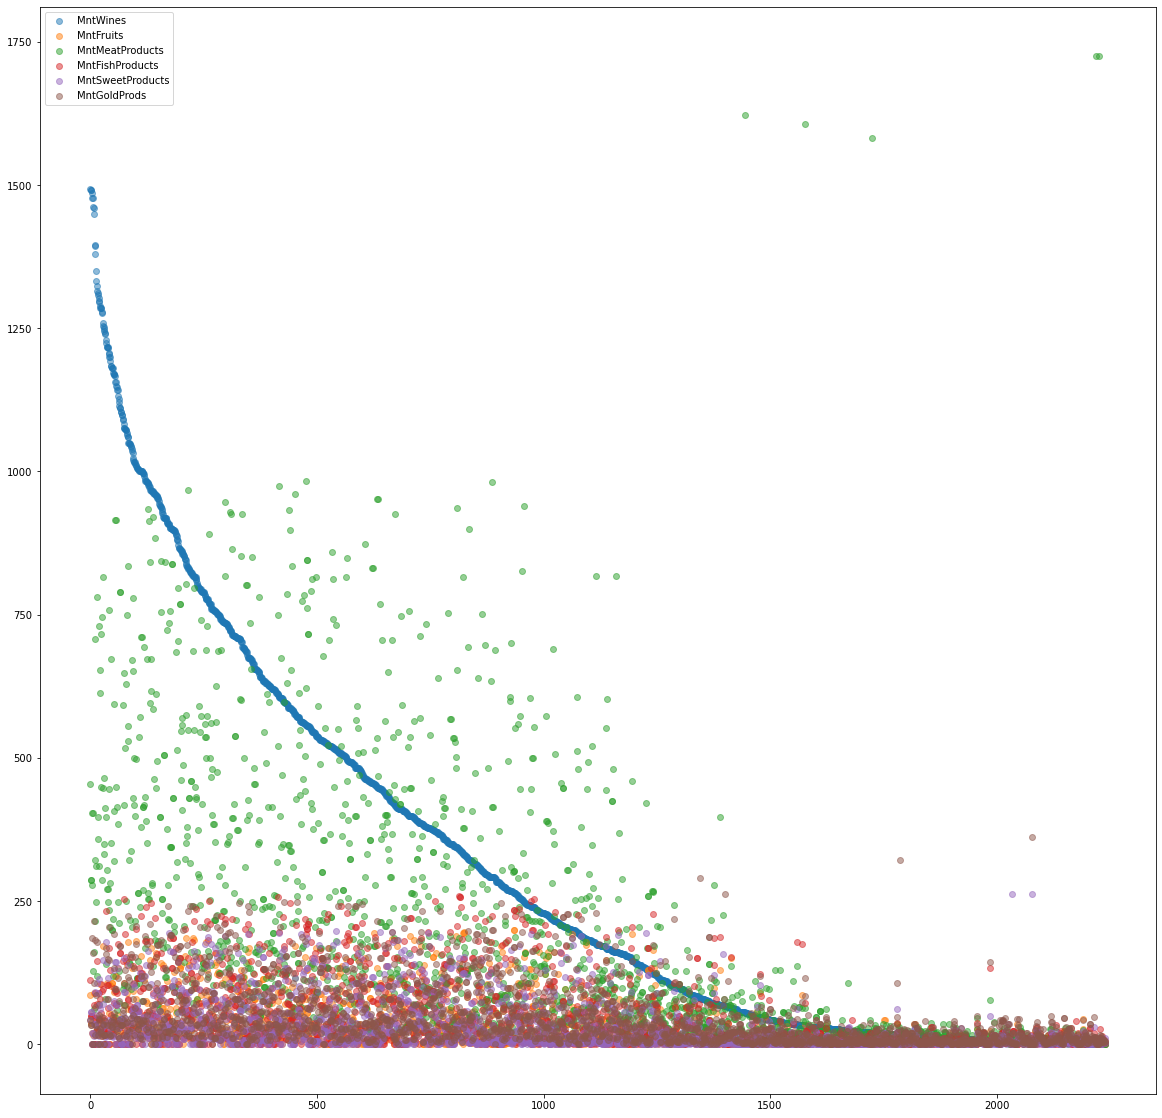

In [112]:
plt.figure(figsize=(20, 20))

df_sorted = df.sort_values(by=mnt_columns, ascending=False)

for mnt_c in mnt_columns:
    plt.scatter(range(df.shape[0]), df_sorted[mnt_c], alpha=.5, label=mnt_c)
    
plt.legend()

* *Ok, não sei bem como analisar melhor, de forma conjunta, esses dados -> seguindo em frente* 

# Aplicando a primeira iteração de feature engineering e limpeza



In [113]:
df = clean_data_1(df)
df = apply_feature_engineering_1(df)

# Relatório gerado pelo pandas_profiling

<a href="../reports/2 - feature_engineering_1.html">Link</a>

## Dados gerados

**Total_Mnt** contém o somatório dos atributos **Mnt**
* *analisar a distribuição conjunta com **Income**.*

**Pct_MntGoldProds** contém a proporção entre **MntGoldProds** e **Total_Mnt**. Ela foi criada assumindo que o total gasto com produtos *gold* seria uma parte do total gasto - ocorre que observei registros com valores de **MntGoldProds** maior que **Total_Mnt**
* *Analisar o registro com esse valor, buscando verificar se há indícios de ser inválido. Em caso positivo, remover do dataset.*

## Total_Mnt

<AxesSubplot:xlabel='Income', ylabel='Total_Mnt'>

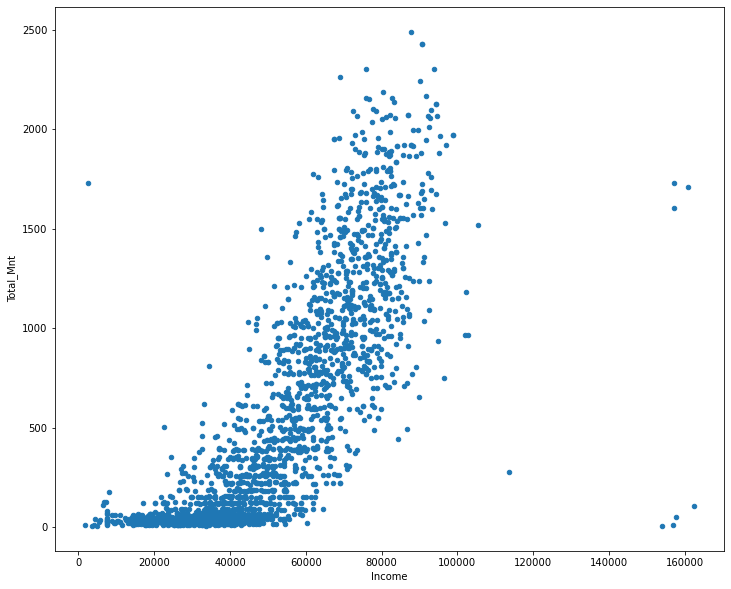

In [114]:
df.plot(kind="scatter", x="Income", y="Total_Mnt", figsize=(12, 10))

* *novamente fica evidente que há registros com um total de consumo alto, mas baixo Income*

## Pct_MntGoldProds

In [115]:
pct_mntgoldprods_gt_1 = df.loc[df["Pct_MntGoldProds"] > 1.0, :]
pct_mntgoldprods_gt_1.T

ID,5255,4246,6237,10311
Year_Birth,1986,1982,1966,1969
Education,Graduation,Master,PhD,Graduation
Marital_Status,Single,Single,Single,Married
Income,NaN,6560.0,7144.0,4428.0
Kidhome,1,0,0,0
Teenhome,0,0,2,1
Dt_Customer,2013-02-20 00:00:00,2013-12-12 00:00:00,2013-12-07 00:00:00,2013-10-05 00:00:00
Recency,19,2,92,0
MntWines,5,67,81,16
MntFruits,1,11,4,4


* *analisando os atributos não identifiquei mais indícios de serem registros inválidos -> vou removê-los da base e registrar um warn informando a situação*

In [116]:
register_warn([
    {
        "id": i, 
        "attr": "Pct_MntGoldProds",
        "type": "outlier",
        "action": "deleted"
    } for i in pct_mntgoldprods_gt_1.index])

# Versão final

A versão final do dataset a ser utilizada para segmentação de clientes e para o modelo de predição de compradores do gadget inclui as colunas geradas durante esse processo e exclui registros classificados como outliers.

O relatório do pandas_profiling pode ser visualizado em <a href="../reports/3 - feature_engineering_2.html">Link</a>.

As colunas ao final são:

In [117]:
df.dtypes

Year_Birth                             int64
Education                             object
Marital_Status                        object
Income                               float64
Kidhome                                int64
Teenhome                               int64
Dt_Customer                   datetime64[ns]
Recency                                int64
MntWines                               int64
MntFruits                              int64
MntMeatProducts                        int64
MntFishProducts                        int64
MntSweetProducts                       int64
MntGoldProds                           int64
NumDealsPurchases                      int64
NumWebPurchases                        int64
NumCatalogPurchases                    int64
NumStorePurchases                      int64
NumWebVisitsMonth                      int64
AcceptedCmp3                           int64
AcceptedCmp4                           int64
AcceptedCmp5                           int64
AcceptedCm

Os registros removidos são os que estão indicados com action = deleted

In [119]:
warns_df = pd.read_csv("../reports/warns.csv")

warns_df.sort_values(by="id")

,id,attr,type,action
5,92,Marital_Status,unknown meaning,nothing
3,433,Marital_Status,unknown meaning,nothing
8,492,Marital_Status,unknown meaning,nothing
2,1150,Year_Birth,outlier,deleted
12,4246,Pct_MntGoldProds,outlier,deleted
7,4369,Marital_Status,unknown meaning,nothing
11,5255,Pct_MntGoldProds,outlier,deleted
13,6237,Pct_MntGoldProds,outlier,deleted
4,7660,Marital_Status,unknown meaning,nothing
6,7734,Marital_Status,unknown meaning,nothing
